# Article writer workflow


![Workflow 01](https://github.com/dinukasaminda/LangGraph-Lessons/blob/main/workflows_drafts/Article%20writer%20workflow.png?raw=true)

In [29]:
# !pip install openai
# !pip install PyYAML
# !pip install langgraph
# !pip install langchain_community
# !pip install langchain_openai

In [30]:
import os, yaml
from openai import OpenAI, ChatCompletion

In [31]:
with open('./credentials.yaml') as f:
    cadentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = cadentials['OPENAI_API_KEY']
os.environ['TAVILY_API_KEY'] = cadentials['TAVILY_API_KEY']

## Define Graph State

In [32]:
from typing import Annotated,Literal,TypedDict
from langgraph.graph.message import add_messages 

class AgentState(TypedDict):
    messages: Annotated[list,add_messages]
    


In [33]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=5)]

## Creating Agents

In [34]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

In [35]:
search_template = """Your job is to search the web for related news that would be relevant to generate the article described by the user.

                  NOTE: Do not write the article. Just search the web for related news if needed and then forward that news to the outliner node.
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article.
                    """

writer_template = """Your job is to write an article, do it in this format:

                        TITLE: <title>
                        BODY: <body>

                      NOTE: Do not copy the outline. You need to write the article but abide by the outline.

                       ```
                    """

In [36]:
from langchain_openai import ChatOpenAI

# Update the ChatOpenAI initialization with model name
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)


search_agent = create_agent(llm, tools, search_template)
outliner_agent = create_agent(llm, [], outliner_template)
writer_agent = create_agent(llm, [], writer_template)

## Define nodes

In [37]:
def agent_node(state, agent, name):
  result = agent.invoke(state)
  return {
      'messages': [result]
  }

In [38]:
import functools

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")

In [39]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Define Edges

In [40]:
# Conditional edge condtion
def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (send state to outliner)
    return "outliner"

## Build Graph

In [41]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)

# add edges
workflow.set_entry_point("search")
workflow.add_conditional_edges(
    "search",
    should_search
)
workflow.add_edge("tools", "search")
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", END)

graph = workflow.compile()

## Visualize Graph

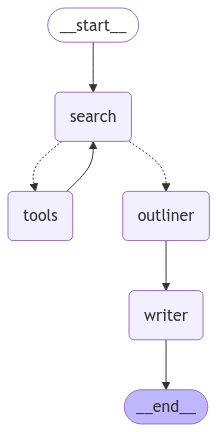

In [42]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Test it out

In [47]:
from langchain_core.messages import HumanMessage

input_message = HumanMessage(content="generate an article about multi agentic worflows")

for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

generate an article about multi agentic worflows
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1LehCeQ6b7j4F46TUcZTmSxt)
 Call ID: call_1LehCeQ6b7j4F46TUcZTmSxt
  Args:
    query: multi agent workflows
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://temporal.io/blog/what-are-multi-agent-workflows", "content": "Temporal is well-suited to support multi-agent workflows because it handles the orchestration, state management, and coordination across different agents (AI or otherwise). Think of Temporal as the \"conductor,\" managing interactions among multiple agents by setting up workflows where agents communicate and pass information as tasks are completed. For multi-agent systems that involve parallel tasks, Temporal’s parallelism and concurre